# Guide 4. Loading and plotting bulk statistics - Deployment 3

This notebook is prepared for Moffat and Nichol by the NCSU Coastal Hazards Lab (Dr. Katherine Anarde, Levi Lavengood, Brooke Gaenzle, Elizabeth Farquhar) for the analysis, interpretation, and visualization of bulk statistics (wave and current velocities) for data collected as part of the Frying Pan Shoals Hydrodynamic Characterization project (2024-2025). This is the second notebook in the series: it summarizes the methods used for calculating bulk statistics and provides a comparison against local wave buoy data. It also summarizes Deployment 3, including the location of the sensors and general climatological conditions.

**Deployment 2: February 02- March 28, 2025** 

On the day of sensor deployment, there were peak wave heights of ~2.5-3.5 ft with periods of ~8 seconds coming from the South. The wind was ~15 knots, with gusts coming from the West. The air temperature was 59 degrees Fahrenheit.

Five ADCPs were deployed during Deployment 3: two by NCSU (S0 and S1, intended to both be on the south-side of Frying Pan Shoals) and three by UNCW (C0, E0, and E1). However, S1 was accdentally deployed at the location of E0 and picked up by a trawler. The ADCPs were secured upward-facing onto landers, which are 2x2x3ft steel frames that were lowered to the sea floor and oriented so their internal compass axes align with the local magnetic declination (~9.5° W). ADCPs were 2 feet off the seafloor. The latitude and longitude of all five sensors' deployment locations are provided in the table below. Upon recovery, both S0 was free of debris and sediment. Notably, S1 was not recovered on March 28, due to the accidental pick up of the lander by a trawler. It was later recovered on April 17. Average water depth was around 30 - 50 feet.

| ADCP |Serial Number| Latitude | Longitude 
| -------| ---------|------------ | ------------ 
| E0 | 103080 | 33°43.812 | 77°56.526
| S0 | 101481 | 33°47.622 | 77°59.022
| C0 | 103071 | 33°48.336 | 77°55.476


*Meteorlogical and oceanographic conditions*:   On March 16 and 17, a strong early spring storm system brought severe weather with tornado touchdowns confirmed in South and North Carolina. A strong thunderstorm enter Pender County on March 16, in the evening, and a waterspout formed over the lower Cape Fear River. The winds were reported to reach a maximum of 95 mph at the tornado touchdown areas.

**Storage**

The bulk statistics are stored in h5 files, like the other processed data files. The main difference for the bulk statistics, is that the groups that the processed data are stored in have been merged for the bulk statistics. This is possible since the bulk statistics are returned for every hour of sampling, so instead of the 14,400 samples per hour across multiple data fields we instead are left with just one averaged value per hour for each data field.

The bulk statistics are calculated in 1 hour averages which we call 'Chunks.' Each chunk consists of several overlapping 512 second segments called ensembles that are averaged together. We choose 512 second long ensembles since the length of the ensemble determines the max period of the waves we can observe, a shorter window and we may miss out on some longer period waves.

In [1]:
### Code to read in h5 files as detailed in the first guidebook
# Import necessary packages
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

In [2]:
deployment_num = 3
sensor_id = ["S0_101418"]
#directory_initial_user_path = r"/Volumes/BOEM/"  # Katherine
directory_initial_user_path = r"/Volumes/kanarde/BOEM/"  # Brooke
# directory_initial_user_path = r"Z:/"  # Levi

In [3]:
# Create dictionary for each sensor
for sensor in sensor_id:
    dirpath=os.path.join(directory_initial_user_path, f"deployment_{deployment_num}/BulkStats/",sensor)
    files = os.listdir(dirpath) # list of files for the sensor
    waves = {}
    for file in files:
        file_path = os.path.join(dirpath, file)  # file path
        df = pd.read_hdf(file_path)  # read the file into a Pandas dataframe
        file_name = file.split('.')[0]  # file name 
        print(file_name)
        waves[file_name] = df  # store dataframe
    globals()[f"waves_{sensor}"] = waves

GroupSpeed
Frequencies
WaveNumbers
Time
WaveCelerity
MeanPeriod
SignificantWaveHeight
DepthAveragedEastVelocity
DepthAveragedNorthVelocity
DepthAveragedUpVelocity
DepthAveragedCurrentVelocity
MeanDirection1
MeanSpread1
MeanDirection2
MeanSpread2
DepthAveragedFlowDirection
PressureSpectra
PressureEastVelCospectra
PressureNorthVelCospectra
EastVelSpectra
NorthVelSpectra
VolumetricBackscatter1
Echo1avg
Vertavg
SedTime
TargetStrength
BottomhalfScatterersavg
TophalfScatterersavg
TopVolumetricBackscatter1
BotVolumetricBackscatter1
Pressure
FullEastVelocity
FullNorthVelocity
FullUpVelocity


## Description of bulk statistics

In the sections that follow, we detail the bulk statistics generated for the deployment. We first review the time variable and then describe statistics generated from the wave energy spectrum. We then conclude with depth-averaged statistics.

**Time**

The time data field stores the datetime associated with each chunk (the time is reported as the midpoint of the time series for each chunk). Time is reported as a unix timestamp in nanoseconds. We provide code for conversion to UTC datetime format below.

In [4]:
#Function to convert unix timestamp in ns to regular datetime in UTC
def unix_ns_to_datetime(unix_ns_array):
    dates = []
    for date in unix_ns_array:
        seconds = date // 1_000_000_000
        nanoseconds = date % 1_000_000_000
        python_datetime = datetime.datetime.utcfromtimestamp(seconds) + datetime.timedelta(microseconds=nanoseconds / 1000)
        dates.append(python_datetime)
    return dates

# print(waves_S0_103080['Time'])
# plt.plot(waves_S0_103080['Time'], label='S0_103080')
# plt.plot(waves_S1_101418['Time'], label='S1_101418')
# plt.legend()

In [5]:
#Applying the function to convert for datetime
unix_ns_array = waves_S0_101418["Time"]
waves_S0_101418["Datetime"] = unix_ns_to_datetime(unix_ns_array[0].values)


In [6]:
#defining the start and end of the data
starttime = pd.to_datetime("2025-02-04 19:10:00", format = '%Y-%m-%d %H:%M:%S') #For deployment 3, S0 was deployed at 3 pm EDT so 7 pm UTC
endtime = pd.to_datetime("2025-03-28 11:30:00", format = '%Y-%m-%d %H:%M:%S') #S0 retrieved at 11 am EDT so 3 pm UTC

### Wave statistics derived from the energy spectrum 

The wave energy spectrum was calculated for each chunk and is represented by the variable PressureSpectra. Here we use Welch's method to generate the wave energy spectrum (Spp), velocity spectra (Suu, Svv), and cospectra (Suv). Spectra are calculated for each hour-long chunk by using 67% overlap for multiple ensembles. Pressure and velocity spectra are corrected for depth attenuation. Significant wave height is calculated as $H_{m_0} = 4*\sqrt{m0}$ where $m_0$ is the zeroth moment. Mean wave period is calculated as $T_{m01} = {m_0} / {m_1}$ where $m_1$ is the first moment.

Below, we plot the spectrogram for each sensor over the deployment to show how wave energy changes with frequency over time.

/var/folders/q5/f29tpv495_l1nlg9kcr2kl0w0000gx/T/ipykernel_7314/295484099.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  fmax=float(freq_nonan.loc[126]) # grab maximum frequency for plotting -


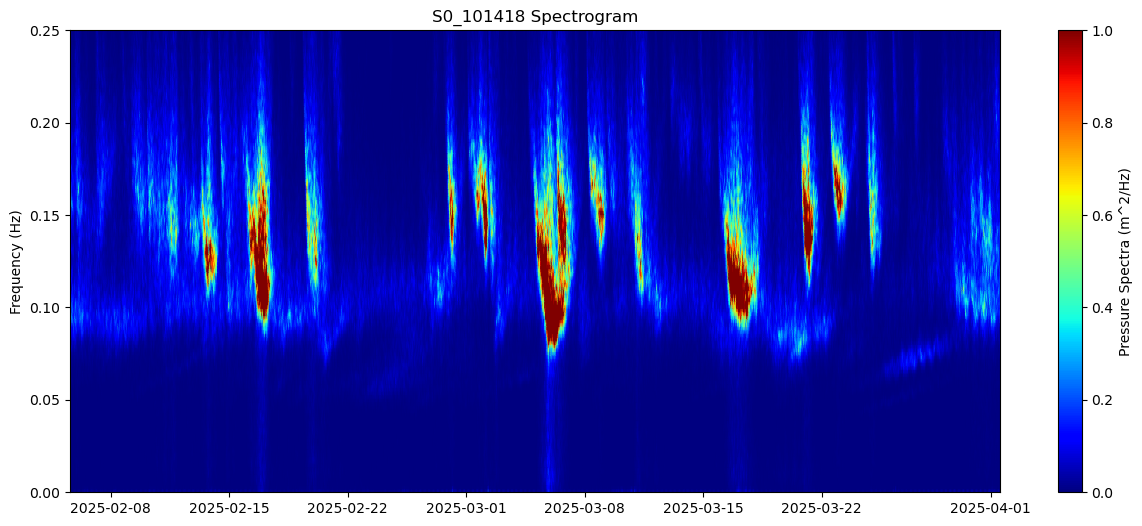

In [7]:
df=waves_S0_101418['PressureSpectra']
df=df.iloc[:,:-1]
# print(df)

freq_nonan=waves_S0_101418['Frequencies'].fillna(0) # fill NaNs with zeros for plotting
fmax=float(freq_nonan.loc[126]) # grab maximum frequency for plotting -
# print(fmax)

# create a meshgrid of time and frequency
x,y=np.meshgrid(waves_S0_101418['Datetime'],freq_nonan)
z=df

# Plot Energy Spectra over time per cell
plt.figure(figsize=(15,6))
plt.pcolormesh(
    x,y,z.T, cmap='jet', shading='gouraud', vmin=0, vmax=1
)
plt.ylim(top=0.25)
plt.ylabel("Frequency (Hz)")
plt.title('S0_101418 Spectrogram')
im1=plt.colorbar()
im1.ax.set_ylabel("Pressure Spectra (m^2/Hz)")
plt.show()

**Mean wave period**

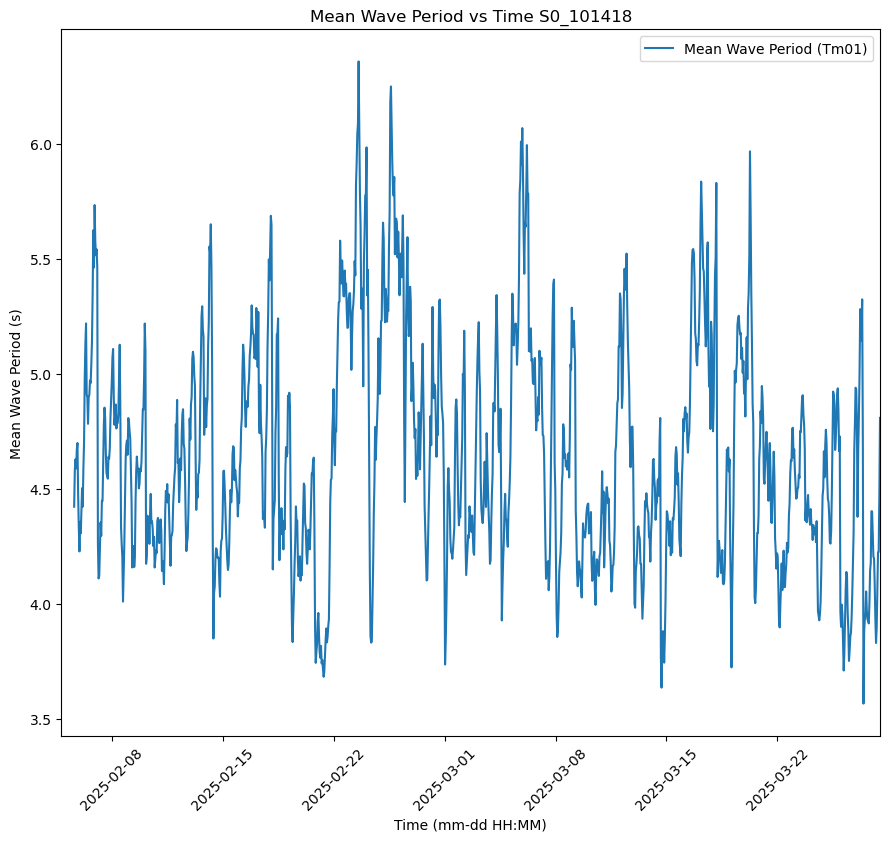

In [9]:
# Plot Mean Wave Period vs Time
fig=plt.figure(figsize=(9,8))

plt.plot(waves_S0_101418["Datetime"], waves_S0_101418["MeanPeriod"], label="Mean Wave Period (Tm01)")
# Formatting
plt.xlabel("Time (mm-dd HH:MM)")
plt.ylabel("Mean Wave Period (s)")
plt.title("Mean Wave Period vs Time S0_101418")
plt.xlim(starttime, endtime)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)


plt.show()

**Significant Wave Height**

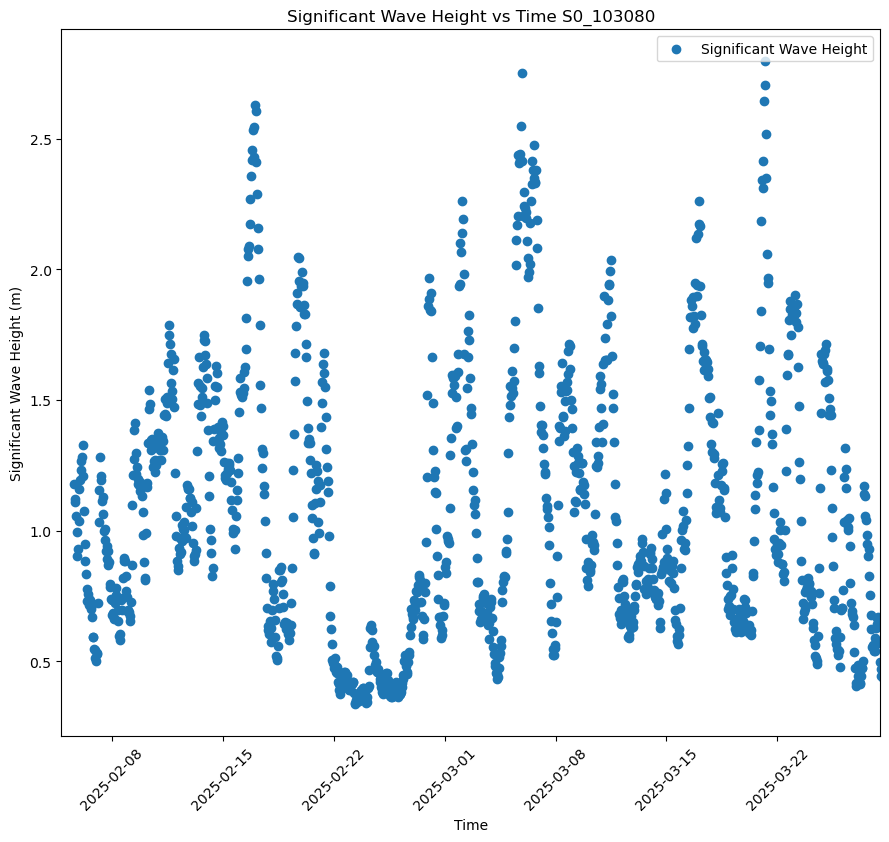

In [10]:
## Plot Mean Wave Period vs Time
fig=plt.figure(figsize=(9,8))

plt.scatter(waves_S0_101418["Datetime"], waves_S0_101418["SignificantWaveHeight"], label="Significant Wave Height")

# Formatting
plt.xlabel("Time")
plt.ylabel("Significant Wave Height (m)")
plt.title("Significant Wave Height vs Time S0_103080")
plt.xlim(starttime, endtime)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)

plt.show()

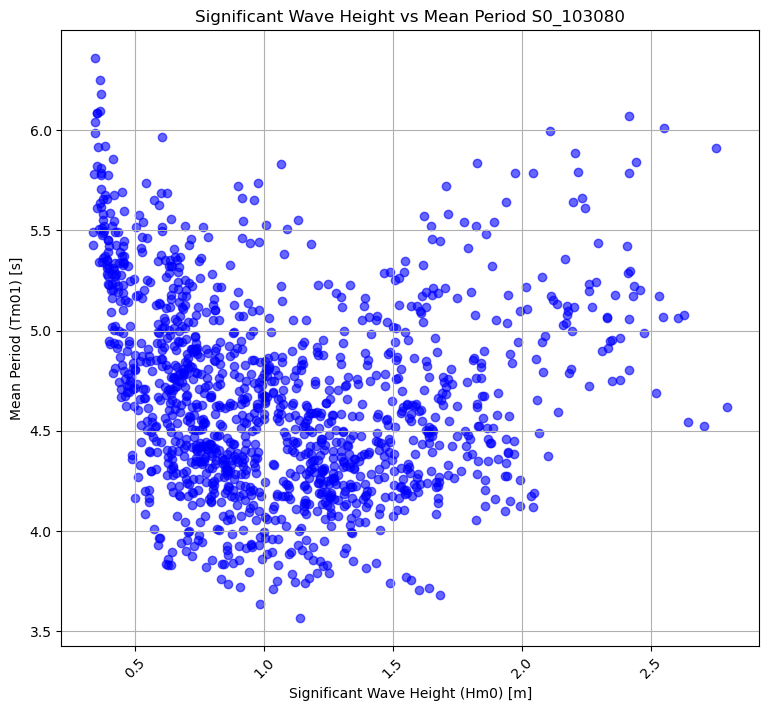

In [11]:
#Plot mean wave period vs significant wave height, you would expect larger waves to have longer periods
# Plot Mean Wave Period vs Significant wave height
fig=plt.figure(figsize=(9,8))

plt.scatter(waves_S0_101418['SignificantWaveHeight'], waves_S0_101418['MeanPeriod'], c='blue', alpha=0.6)
plt.title('Significant Wave Height vs Mean Period S0_103080')
plt.xlabel('Significant Wave Height (Hm0) [m]')
plt.ylabel('Mean Period (Tm01) [s]')
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

**Wave Direction and Spread**

The wave direction contains the average direction of wave groups and the spread of this measurement. The direction is measured in degrees from North (i.e., East = 90, South = 180, West = 270, North = 0 or 360). The spread refers to the deviation in degrees that the wave packets may travel from the mean direction. So a direction of 90 and a spread of 45 means you would expect the wave packets to be traveling on average due east with parts of the wave packet propogating from ENE to ESE.

The first and second order wave directions and directional spread are calculated using a weighted average of fourier coefficients from both cospectra (coPU, coPV) and power spectra (Suu, Svv, Spp).

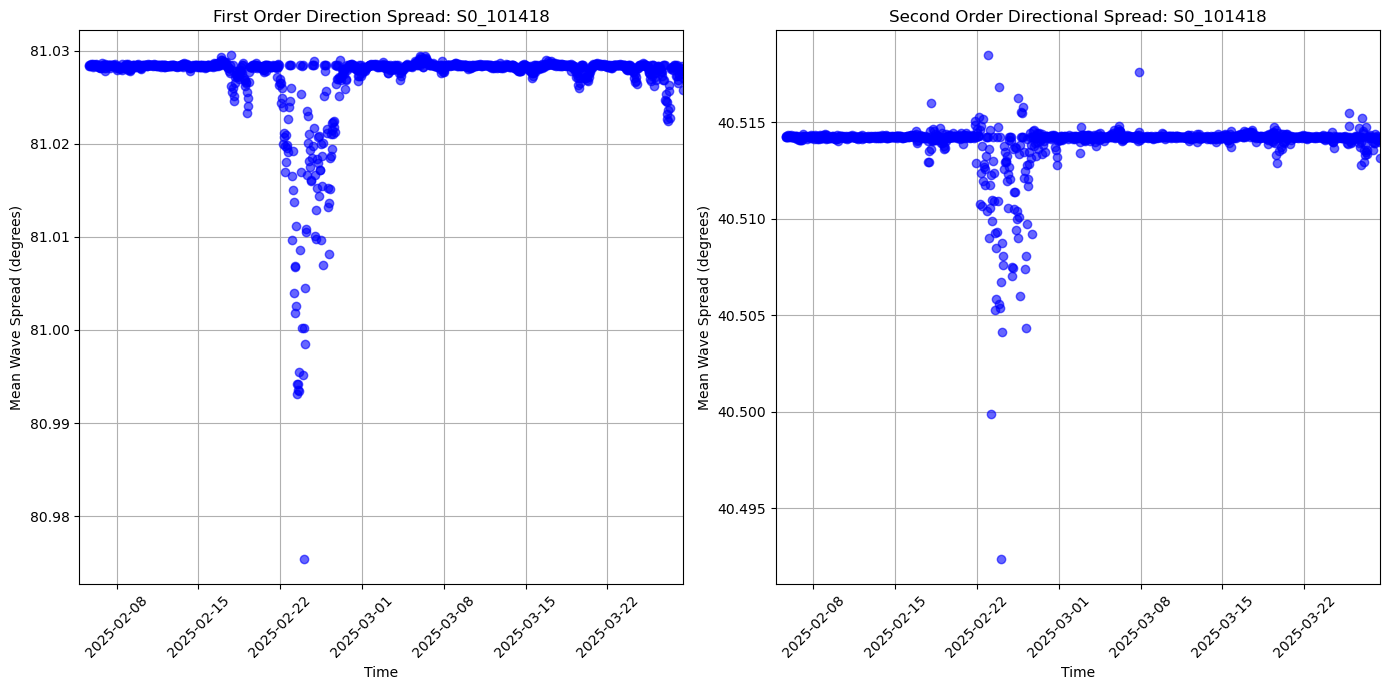

In [12]:
#This compares the first and second order spreads 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
ax1.plot(waves_S0_101418["Datetime"], waves_S0_101418["MeanSpread1"], 'o', linestyle='none', c='blue', alpha=0.6)
ax1.set_title('First Order Direction Spread: S0_101418')
ax2.plot(waves_S0_101418["Datetime"], waves_S0_101418["MeanSpread2"], 'o', linestyle='none', c='blue', alpha=0.6)
ax2.set_title('Second Order Directional Spread: S0_101418')
for ax in (ax1, ax2):
    ax.set_xlabel('Time')
    ax.set_ylabel('Mean Wave Spread (degrees)')
    ax.set_xlim(starttime, endtime)
    ax.grid(True)
    ax.tick_params(axis='x', labelrotation=45)
plt.tight_layout()    

#Code to compare first and second order mean wave direction 
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
# ax1.plot(waves_S0_103080["Datetime"], waves_S0_103080["MeanDirection1"], 'o', linestyle='none', c='blue', alpha=0.6)
# ax1.set_title('First Order Mean Wave Direction vs Time S0_103080')
# ax2.plot(waves_S0_103080["Datetime"], waves_S0_103080["MeanDirection2"], 'o', linestyle='none', c='blue', alpha=0.6)
# ax2.set_title('Second Order Mean Wave Direction vs Time S0_103080')
# for ax in (ax1, ax2):
#     ax.set_xlabel('Time')
#     ax.set_ylabel('Mean Wave Direction (degrees)')
#     ax.set_xlim(starttime, endtime)
#     ax.grid(True)
#     ax.tick_params(axis='x', labelrotation=45)
# plt.tight_layout()

ValueError: not enough values to unpack (expected 2, got 0)

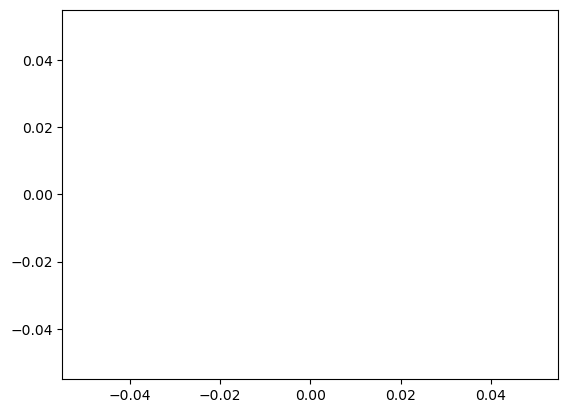

In [14]:
#Create a polar plot of wave direction with signficant wave height as the color to show the intensity of the waves
#Use the spread of the wave direction to show the variability of the waves
fig, (ax1) = plt.plot(kw={'projection': 'polar'}, figsize=(16, 7),sharey=True)
# Plotting the wave direction
ax1.scatter(np.radians(waves_S0_101418['MeanSpread1']),waves_S0_101418['SignificantWaveHeight'] ,c = 'blue', alpha=0.6, label='First Order')
ax1.scatter(np.radians(waves_S0_101418['MeanSpread2']),waves_S0_101418['SignificantWaveHeight'] ,c = 'red', alpha=0.6, label='Second Order')
ax1.set_title('Sensor S0_101418')
ax1.yaxis.set_label_coords(-0.1, 0.5)

for ax in (ax1):
    ax.legend(loc='upper right')   
    ax.set_theta_direction(-1)  # Set the direction of the angle to be clockwise
    ax.set_theta_zero_location('N')  # Set the zero angle to the top
    ax.set_xlabel('Mean Wave Direction (degrees)')
    ax.set_ylabel('Significant Wave Height (m)')
plt.tight_layout()


### Depth-averaged statistics

All velocity variables -- including U (easting), V (northing), vertical (up), and current velocity -- are reported as a depth average.

**Depth Averaged Current Velocity and Direction**

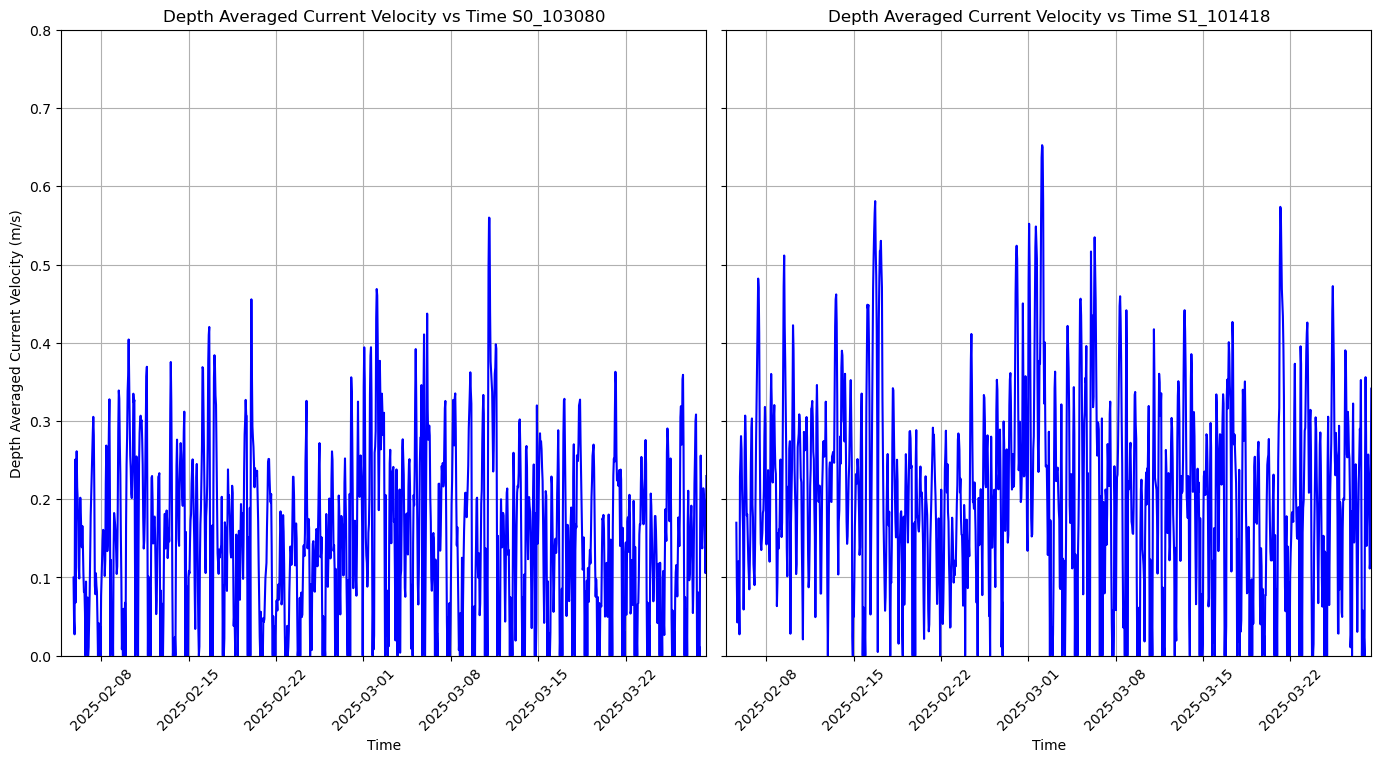

In [14]:
#This code plots the Depth Averaged Current Velocity vs Time for both sensors
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
ax1.plot(waves_S0_103080["Datetime"], waves_S0_103080['DepthAveragedCurrentVelocity'], label='Depth Averaged Current Velocity', color='blue')
ax1.set_title('Depth Averaged Current Velocity vs Time S0_103080')
ax1.set_ylabel('Depth Averaged Current Velocity (m/s)')
ax2.plot(waves_S1_101418["Datetime"], waves_S1_101418['DepthAveragedCurrentVelocity'], label='Depth Averaged Current Velocity', color='blue')
ax2.set_title('Depth Averaged Current Velocity vs Time S1_101418')
plt.tight_layout()
for ax in (ax1, ax2):
    ax.set_xlabel('Time')
    #ax.set_ylabel('Depth Averaged Current Velocity (m/s)')
    ax.set_xlim(starttime, endtime)
    ax.set_ylim(0, 0.8)
    ax.grid(True)
    ax.tick_params(axis='x', labelrotation=45)

Text(0.5, 1.0, 'Sensor S1_101418')

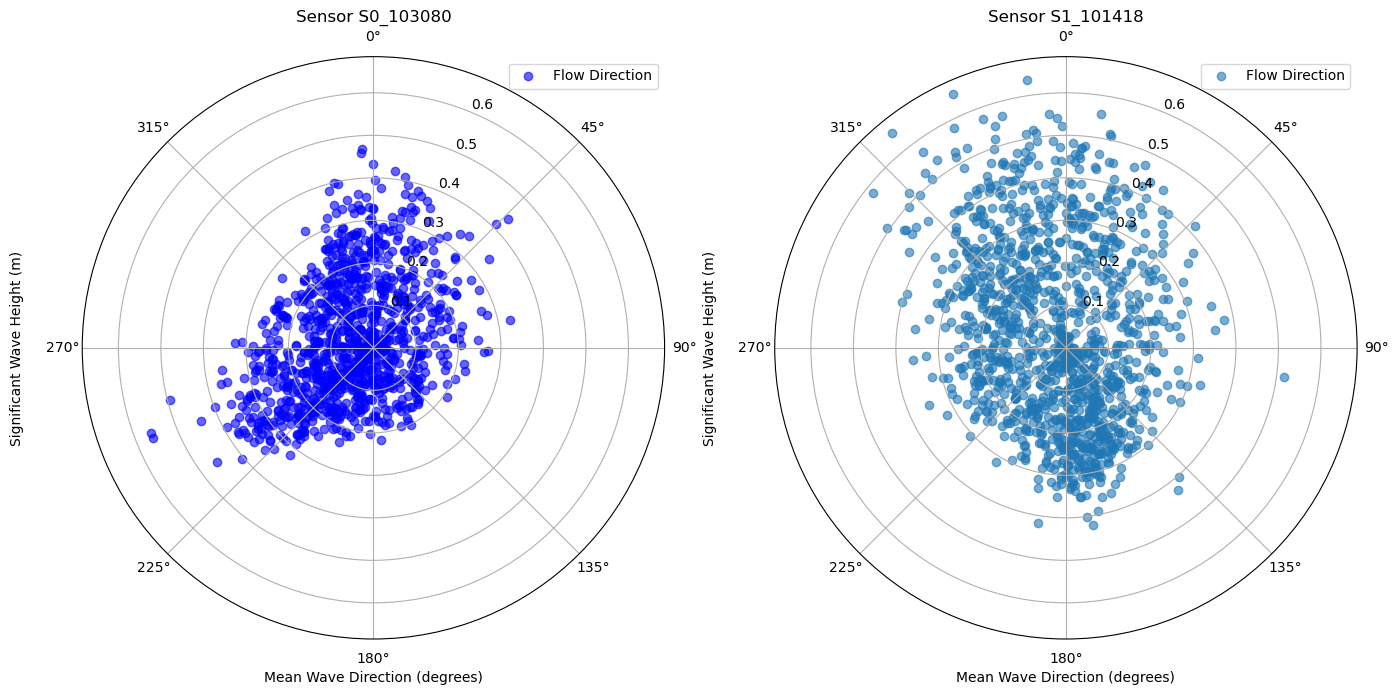

In [15]:
#Create a polar plot of flow direciton with average flow velocity to show the intensity of the flow
#Use the spread of the wave direction to show the variability of the waves
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(14, 7),sharey=True)
# Plotting the wave direction
ax1.scatter(np.radians(waves_S0_103080['DepthAveragedFlowDirection']),waves_S0_103080['DepthAveragedCurrentVelocity'] ,c = 'blue', alpha=0.6, label='Flow Direction')
ax1.set_title('Sensor S0_103080')
ax1.yaxis.set_label_coords(-0.1, 0.5)
ax2.scatter(np.radians(waves_S1_101418['DepthAveragedFlowDirection']) ,waves_S1_101418['DepthAveragedCurrentVelocity'] , alpha=0.6, label='Flow Direction')
ax2.yaxis.set_label_coords(-0.1, 0.5)
for ax in (ax1, ax2):
    ax.legend(loc='upper right')   
    ax.set_theta_direction(-1)  # Set the direction of the angle to be clockwise
    ax.set_theta_zero_location('N')  # Set the zero angle to the top
    ax.set_xlabel('Mean Wave Direction (degrees)')
    ax.set_ylabel('Significant Wave Height (m)')
plt.tight_layout()
ax2.set_title('Sensor S1_101418')

## Data Comparison

We can compare our data to that collected by the Coastal Ocean Research and Monitoring Program (CORMP). There is SOFAR spotter wave buoy located east of Bald Head Island at 33.8684 N 77.9396 W, and will be denoted here as BHI_E. This is further onshore than where our ADCPs were recording data (closer to Bald Head Island). There is another bouy located just outside of the shoals at 33.721 N 78.015 W, owned by the U.S. Army Corps of Engineers. This buoy is close to lander S0 and S1, at a water depth of 13 m and will be denoted as USACE_41108.

In [16]:
# Read in BHI-E Data
BHI_E_path=r"/Volumes/kanarde/BOEM/deployment_3/BulkStats/CORMP_data/data_BHI_E.csv"
BHI_E_data=pd.read_csv(BHI_E_path,skiprows=10)

In [17]:
## Assign variables for BHI-E buoy
Bdf={}
Bdf["BTime"]=BHI_E_data['Time (America/New_York)']
Bdf["BSigWaveHeight"]=BHI_E_data['BHI-E Significant wave height (ft)']*0.3048 # convert from feet to meters
Bdf["BMeanPeriod"]=BHI_E_data['BHI-E Mean wave period (s)']
Bdf["BMeabWaveDirection"]=BHI_E_data['BHI-E Mean wave direction (deg N)']


In [18]:
# convert to datetime format
Bdf["BTime"] = pd.to_datetime(Bdf["BTime"])

start_date = '2025-02-04'
end_date = '2025-03-28'

# Convert start and end dates to datetime format
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# Filter the data based on the date range
filtered_Bdf = {key: value[(Bdf["BTime"] >= start_date) & (Bdf["BTime"] <= end_date)] for key, value in Bdf.items()}

Bdf=filtered_Bdf

/var/folders/q5/f29tpv495_l1nlg9kcr2kl0w0000gx/T/ipykernel_64400/1420876437.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Bdf["BTime"] = pd.to_datetime(Bdf["BTime"])


In [19]:
# read in USACE data
USACEpath=r"/Volumes/kanarde/BOEM/deployment_1/BulkStats/CORMP_data/41108h2024.txt"
df = pd.read_csv(USACEpath, delim_whitespace=True, header=1)

In [20]:
# convert time
df.rename(columns={'#yr': 'yr'}, inplace=True)
df['Datetime'] = pd.to_datetime(df['yr'].astype(str) + '-' +
                                 df['mo'].astype(str).str.zfill(2) + '-' +
                                 df['dy'].astype(str).str.zfill(2) + ' ' +
                                 df['hr'].astype(str).str.zfill(2) + ':' +
                                 df['mn'].astype(str).str.zfill(2))

In [21]:
# Filter rows based on the date range
filtered_df = df[(df['Datetime'] >= start_date) & (df['Datetime'] <= end_date)]
USACEdata=filtered_df
UStime=filtered_df['Datetime']

In [22]:
# assign variables for USACE buoy
USSigWaveHeight=USACEdata["m"]
USMeanPeriod=USACEdata["sec.1"]
USMeanWaveDirection=USACEdata["degT.1"]

Let's compare our data to that collected during the same time period through the CORMP buoy, starting with mean wave period. (NOTE: Ocean Current data is not yet available on USACE database)

In [23]:
# Define custom dates for the x-ticks
custom_xticks = [
    "02/04/25","02/10/25", "02/16/25", "02/22/25", "02/28/25", "03/05/25", "03/11/25", "03/17/25","03/23/25","03/28/25"
]
# Convert these dates to datetime format
custom_xticks = pd.to_datetime(custom_xticks, format='%m/%d/%y')

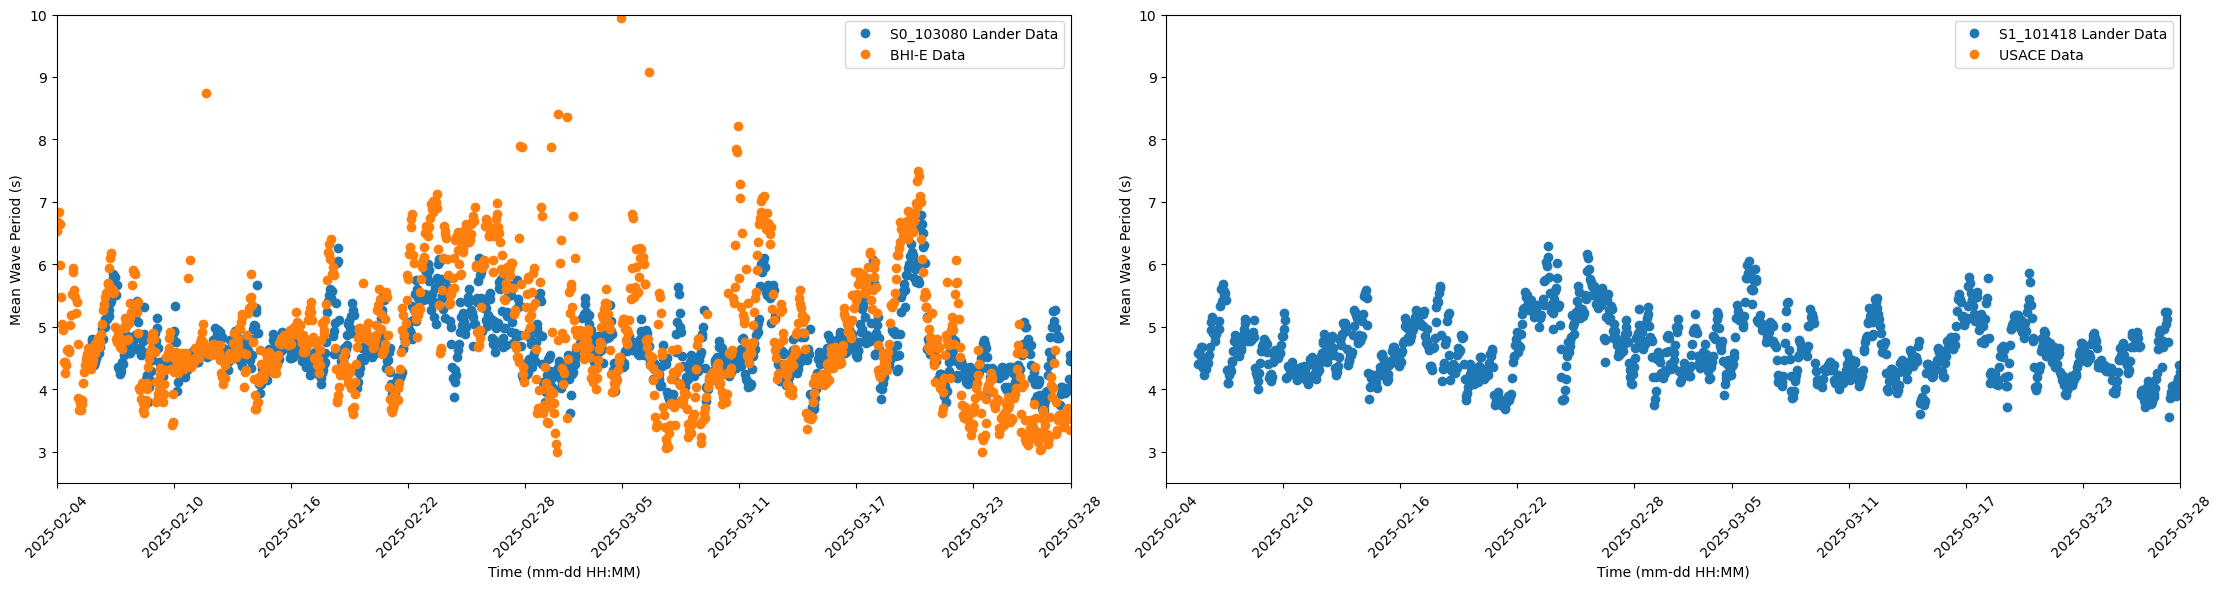

In [24]:
# Plot Mean Wave Period vs Time
fig=plt.figure(figsize=(22,6))
plt.subplot(1,2,1)
plt.plot(waves_S0_103080["Datetime"], waves_S0_103080["MeanPeriod"], label="S0_103080 Lander Data",marker='o',linestyle='')
plt.plot(Bdf["BTime"], Bdf["BMeanPeriod"], label="BHI-E Data",marker='o',linestyle='')

# Formatting
plt.xlabel("Time (mm-dd HH:MM)")
plt.ylabel("Mean Wave Period (s)")
plt.ylim(2.5,10)
plt.xlim(start_date,end_date)
plt.legend()
plt.tight_layout()

plt.xticks(custom_xticks,rotation=45)

plt.subplot(1,2,2)
plt.plot(waves_S1_101418["Datetime"], waves_S1_101418["MeanPeriod"], label="S1_101418 Lander Data",marker='o',linestyle='')
plt.plot(UStime, USMeanPeriod, label="USACE Data",marker='o',linestyle='')

# Formatting
plt.xlabel("Time (mm-dd HH:MM)")
plt.ylabel("Mean Wave Period (s)")
plt.ylim(2.5,10)
plt.xlim(start_date,end_date)
plt.legend()
plt.tight_layout()

plt.xticks(custom_xticks,rotation=45)


plt.show()

We can also compare our calculated significant wave heights with that of the offshore buoys.

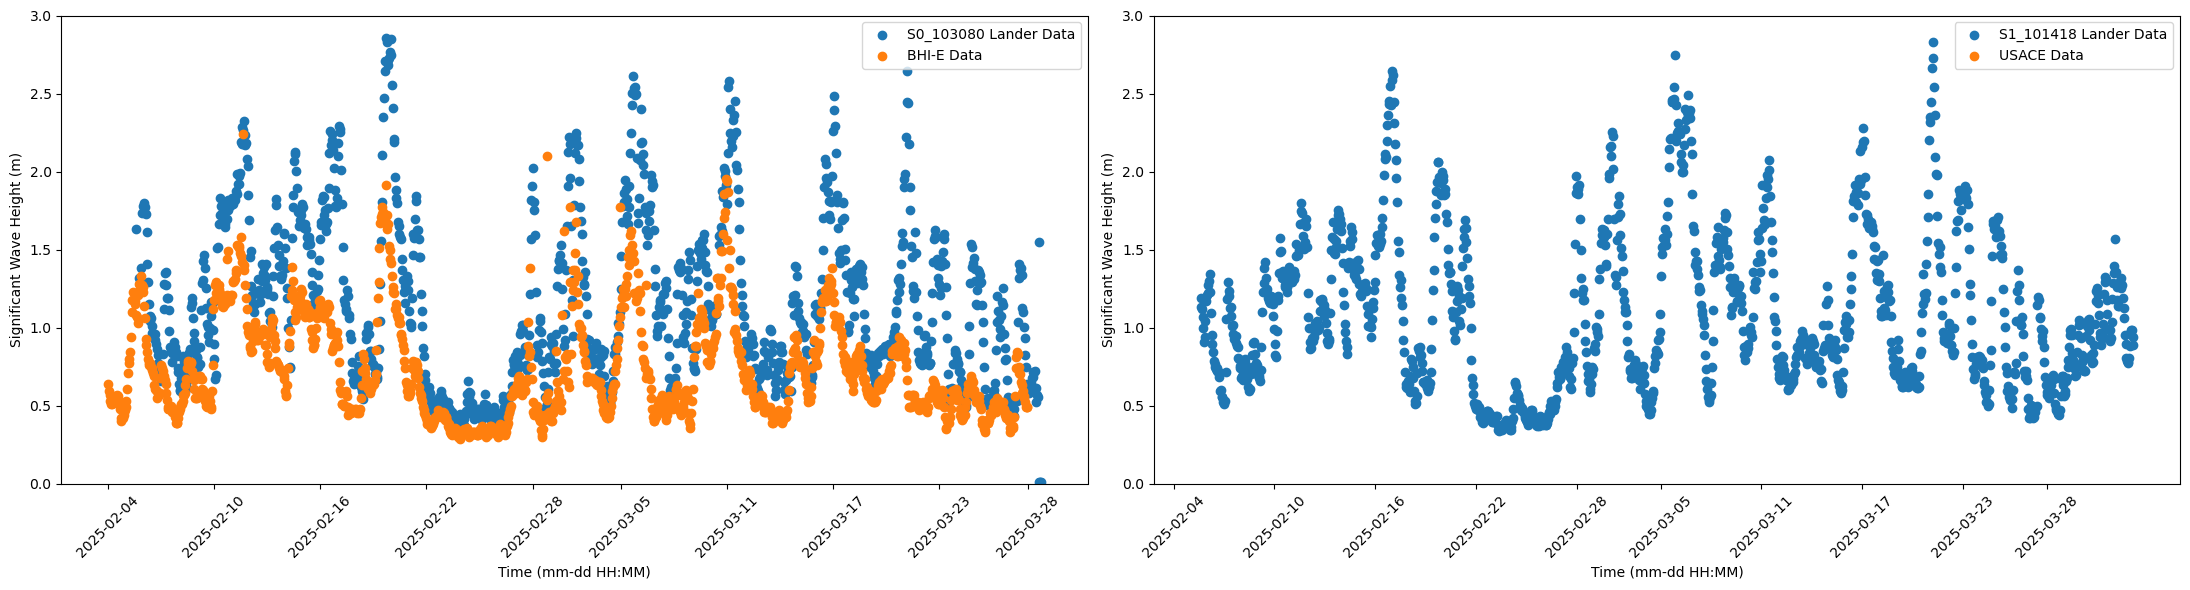

In [25]:
# Plot Significant Wave Height vs Time
fig=plt.figure(figsize=(22,6))
plt.subplot(1,2,1)
plt.scatter(waves_S0_103080["Datetime"], waves_S0_103080['SignificantWaveHeight'], label="S0_103080 Lander Data")
plt.scatter(Bdf["BTime"], Bdf["BSigWaveHeight"], label="BHI-E Data")

# Formatting
plt.xlabel("Time (mm-dd HH:MM)")
plt.ylabel("Significant Wave Height (m)")
plt.ylim(0,3)
plt.legend()
plt.tight_layout()

plt.xticks(custom_xticks,rotation=45)

plt.subplot(1,2,2)
plt.scatter(waves_S1_101418["Datetime"], waves_S1_101418['SignificantWaveHeight'], label="S1_101418 Lander Data")
plt.scatter(UStime, USSigWaveHeight, label="USACE Data")

# Formatting
plt.xlabel("Time (mm-dd HH:MM)")
plt.ylabel("Significant Wave Height (m)")
plt.ylim(0,3)
plt.legend()
plt.tight_layout()

plt.xticks(custom_xticks,rotation=45)


plt.show()

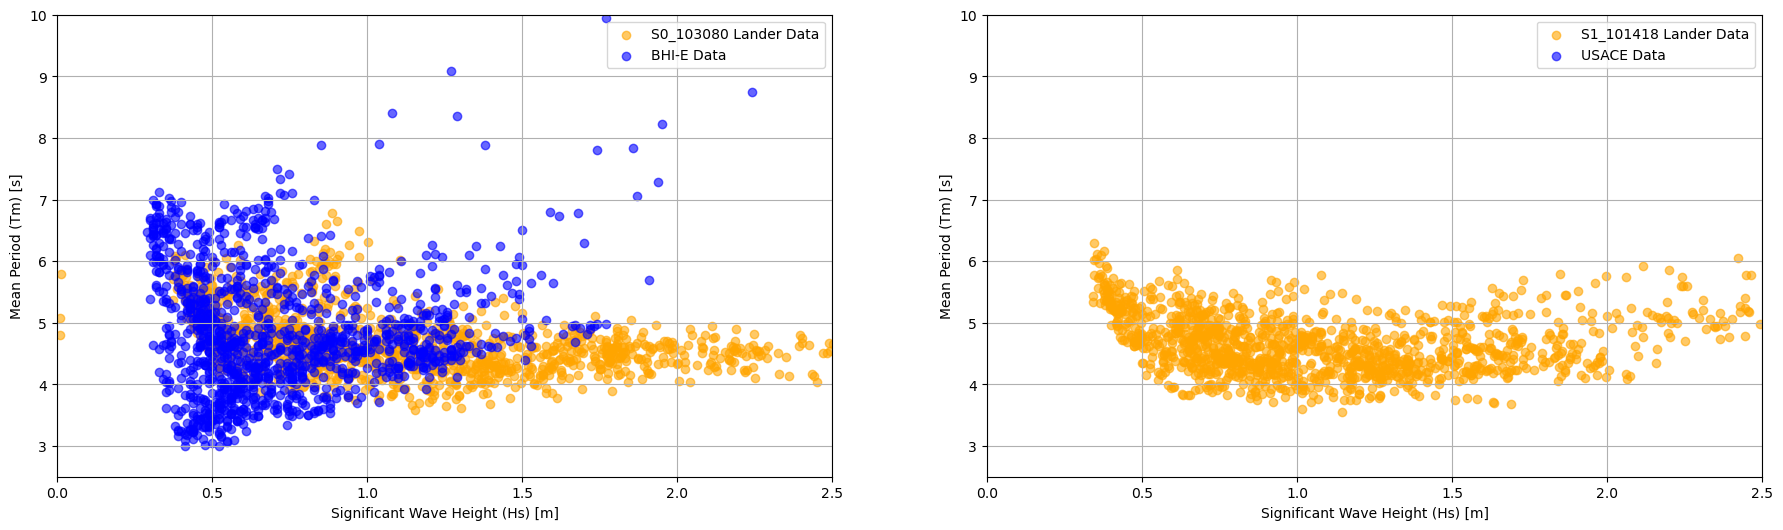

In [26]:
#Plot mean wave period vs significant wave height, you would expect larger waves to have longer periods
fig=plt.figure(figsize=(22,6))
plt.subplot(1,2,1)
plt.scatter(waves_S0_103080['SignificantWaveHeight'], waves_S0_103080['MeanPeriod'], c='orange', alpha=0.6, label="S0_103080 Lander Data")
plt.scatter(Bdf['BSigWaveHeight'],Bdf['BMeanPeriod'], c='blue', alpha=0.6, label="BHI-E Data")

# Formatting
plt.xlabel('Significant Wave Height (Hs) [m]')
plt.ylabel('Mean Period (Tm) [s]')
plt.ylim(2.5,10)
plt.xlim(0,2.5)
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.scatter(waves_S1_101418['SignificantWaveHeight'], waves_S1_101418['MeanPeriod'], c='orange', alpha=0.6, label="S1_101418 Lander Data")
plt.scatter(USSigWaveHeight,USMeanPeriod, c='blue', alpha=0.6, label="USACE Data")

# Formatting
plt.xlabel('Significant Wave Height (Hs) [m]')
plt.ylabel('Mean Period (Tm) [s]')
plt.ylim(2.5,10)
plt.xlim(0,2.5)
plt.legend()
plt.grid(True)


plt.show()